In [557]:
import numpy as np
from numpy.random import rand, randn
from numpy import ones, exp, log, diag, vstack, pi, array, r_, isfinite, logspace, zeros, eye
from numpy.linalg import norm, solve
from numpy.random import default_rng
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN
from scipy.special import ndtri, ndtr
from scipy.stats import uniform as udist
from scipy.stats import norm as ndist
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from warnings import catch_warnings, filterwarnings
import time

from RWM import RWM
from Manifolds.Manifold import Manifold
from tangential_hug_functions import HugTangentialMultivariate
import arviz
from utils import ESS_univariate
from seaborn import kdeplot

from copy import deepcopy
from matplotlib import rc
import seaborn as sns

The posterior distribution for the G and K distribution is
$$
p(\theta\mid y) \propto p(y\mid \theta) p(\theta)
$$
where the prior distribution is $p(\theta) = \prod_{i=1}^4\mathcal{U}(\theta;[0, 10])$. Let us work on the augmented space with the latent variables $z\sim\mathcal{N}(0, I_m)$. Recall that the data is produced as
$$
y = f(\theta, z).
$$
Therefore the augmented posterior will lie on the manifold
$$
\mathcal{M} = \left\{\theta, z\,:\, f(\theta, z) = y\right\}
$$
and its density with respect to the Hausdorff measure is
$$
p(\theta, z \mid y) \propto p(z) p(\theta) \left|J_f(\theta, z) J_f(\theta, z)^\top\right|^{-1/2}.
$$


Now consider only the prior over $\theta = (a, b, g, k) = (\theta_1, \theta_2, \theta_3, \theta_4)$. Clearly, for each component $i\in\{1, \ldots, 4\}$ we have by the Inverse Transform Sampling theorem that
$$
\theta_i = 10\Phi(\vartheta_i) \qquad \vartheta_i\sim\mathcal{N}(0, 1)
$$
which we can write as $\theta_i = F(\vartheta_i)$ with $F(\cdot) = 10\Phi(\cdot)$ and $\Phi$ being the CDF of a standard normal distribution. If we define $G(\theta) = (F(\theta_1), \ldots, F(\theta_4))$ then we have by the change of variables formula (since $\theta = G(\vartheta)$)
$$
p_\theta(\theta) = p_\vartheta(G^{-1}(\theta))\left|J_{G^{-1}}(\theta)\right|
$$
Therefore the posterior distribution should be
$$
p(\theta\mid y) \propto p(y\mid G^{-1}(\theta)) p_\vartheta(G^{-1}(\theta))\left|J_{G^{-1}}(\theta)\right|
$$
and similarly the extended posterior will be
$$
\begin{align}
    p(\theta, z \mid y) 
    &\propto p(z) p_\theta(\theta)\left|J_f(\theta, z) J_f(\theta, z)^\top\right|^{-1/2} \\
    &\propto p(z) p_\vartheta(G^{-1}(\theta))\left|J_{G^{-1}}(\theta)\right| \left|J_f(\theta, z) J_f(\theta, z)^\top\right|^{-1/2}
\end{align}
$$

But in practice do I want to sample from that or from $p(\vartheta, z\mid y)$?

Basically this is what we want:

- Run algorithm on unconstrained $\theta$ space.
- Accept-Reject based on a density (in the unconstrained space) that is equivalent to the density in the constrained space
- At the end, transform the samples from the unconstrained space back into the constrained space.

Since $\theta = G(\vartheta)$ one has $\vartheta = G^{-1}(\theta)$. Then by the change of variables formula
$$
p_\vartheta(\vartheta) = p_\theta(G(\vartheta))\left|J_G(\vartheta)\right|.
$$
The posterior distribution would then be
$$
\begin{align}
    p_\vartheta(\vartheta\mid y) 
    &\propto p_\vartheta(\vartheta) p(y \mid G(\vartheta)) \\
    &\propto p_\theta(G(\vartheta)) \left|J_G(\vartheta)\right|p(y \mid G(\vartheta))
\end{align}
$$


And the posterior distribution on the manifold would then be
$$
p_\vartheta(\vartheta, z \mid y) \propto p(z) p_\theta(G(\vartheta)) \left|J_G(\vartheta)\right| \left|J_f(G(\vartheta), z) J_f(G(\vartheta), z)^\top\right|^{-1/2}
$$

Next step is to figure out and code the mapping $G:\vartheta\to\theta$ that maps a normal random variable $\vartheta\sim\mathcal{N}(0, I_4)$ to a Uniformly distributed random variable $\theta\sim\mathcal{U}([0, 10]^4)$.

HOLD THE FUCK UP. I AM MISSING A JACOBIAN TERM.

The new constraint function is
$$
f_{new} = f \circ \overline{G}
$$
where $\overline{G} = [G(\vartheta), z]$. Therefore the new Jacobian defining the manifold will have to be
$$
J_{f_{new}} (\xi) = J_f(\overline{G}(\xi)) J_{\overline{G}}(\xi)
$$

In our case the Jacobian of $\overline{G}$ is simply
$$
J_{\overline{G}}(\xi) = 
\begin{pmatrix}
    J_G(\vartheta) & 0 \\
    0 & I_m
\end{pmatrix}
$$

# Transformation from Uniform to Normal and vice-versa

In [2]:
N = 1000000

In [3]:
def standard_normal_xvals_yvals(n):
    """Generates x and y values for a N(0, 1) plot."""
    xvalues = np.linspace(-5, 5, num=n)
    return xvalues, ndist.pdf(xvalues)

def uniform_on_0_10_to_standard_normal(θ):
    """Given samples ~U(0, 10) it transforms them to samples ~N(0,1)."""
    return ndtri(θ/10)

def standard_normal_to_uniform_on_0_10(varθ):
    """Given samples ~N(0, 1) it transforms them to samples ~U(0, 10)."""
    return 10*ndtr(varθ)

In [4]:
# Uniform --> Normal
uniform_samples = udist.rvs(loc=0.0, scale=10.0, size=N)
uniform_to_normal_samples = uniform_on_0_10_to_standard_normal(uniform_samples)

# Normal --> Uniform
normal_samples = ndist.rvs(loc=0.0, scale=1.0, size=N)
normal_to_uniform_samples = standard_normal_to_uniform_on_0_10(normal_samples)

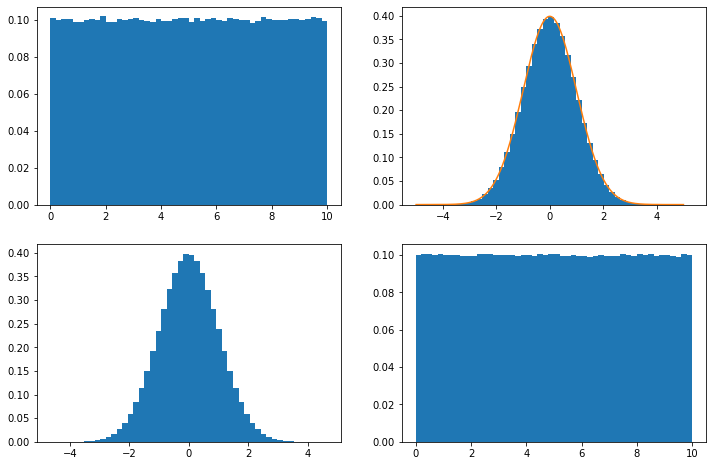

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# Uniform -> Normal
_ = ax[0, 0].hist(uniform_samples, bins=50, density=True)
_ = ax[0, 1].hist(uniform_to_normal_samples, bins=50, density=True)
ax[0, 1].plot(*standard_normal_xvals_yvals(N))
# Normal -> Uniform
_ = ax[1, 0].hist(normal_samples, bins=50, density=True)
_ = ax[1, 1].hist(normal_to_uniform_samples, bins=50, density=True)
plt.show()

# Inverse Sampling Transform

My aim is to sample from $U(0, 10)$ but I want to do this by sampling on an unconstrained space. For this reason, I sample on the unconstrained space targeting $N(0, 1)$ but using the transform.

In [6]:
# Rename functions using the notation above
G    = standard_normal_to_uniform_on_0_10
Ginv = uniform_on_0_10_to_standard_normal

In [7]:
pθ    = lambda θ: udist.pdf(θ, loc=0.0, scale=10.0).prod()
logpθ = lambda θ: udist.logpdf(θ, loc=0.0, scale=10.0).sum()
log_abs_det_jac = lambda varθ: ndist.logpdf(varθ).sum()
logpvarθ = lambda varθ: logpθ(G(varθ)) + log_abs_det_jac(varθ)

In [8]:
varθ0 = randn(4)

In [9]:
unconstrained_samples, acc = RWM(varθ0, 1.0, 100000, logpvarθ)

In [10]:
constrained_samples = standard_normal_to_uniform_on_0_10(unconstrained_samples)

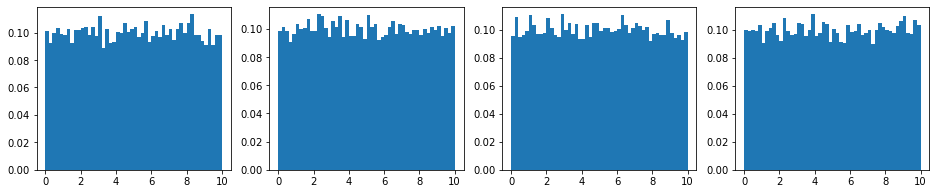

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))
for i in range(4):
    _ = ax[i].hist(constrained_samples[:, i], density=True, bins=50)
plt.show()

# G and K distribution with $U(0, 10)$ prior reparametrized to $N(0, 1)$

In [455]:
class GKManifold(Manifold):
    def __init__(self, ystar):
        self.m = len(ystar)            # Number constraints = dimensionality of the data
        self.d = 4                     # Manifold has dimension 4 (like the parameter θ)
        self.n = self.d + self.m       # Dimension of ambient space is m + 4
        self.ystar = ystar
        # N(0, 1) ---> U(0, 10).
        self.G    = lambda θ: 10*ndtr(θ)
        # U(0, 10) ---> N(0, 1)
        self.Ginv = lambda θ: ndtri(θ/10)

    def q(self, ξ):
        """Constraint for G and K."""
        ξ = r_[self.G(ξ[:4]), ξ[4:]]   # expecting theta part to be N(0, 1)
        with catch_warnings():
            filterwarnings('error')
            try:
                return (ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]) - self.ystar
            except RuntimeWarning:
                raise ValueError("Constraint found Overflow warning.")
                
    def _q_raw_uniform(self, ξ):
        """Constraint function expecting ξ[:4] ~ U(0, 10). It doesn't do any warning check."""
        return (ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]) - self.ystar
    def _q_raw_normal(self, ξ):
        """Same as `_q_raw_uniform` except expects ξ[:4]~N(0,1)."""
        ξ = r_[self.G(ξ[:4]), ξ[4:]] 
        return self._q_raw_uniform(ξ)

    def Q(self, ξ):
        """Transpose of Jacobian for G and K. """
        ξ = r_[self.G(ξ[:4]), ξ[4:]]
        return vstack((
        ones(len(ξ[4:])),
        (1 + 0.8 * (1 - exp(-ξ[2] * ξ[4:])) / (1 + exp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
        8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * exp(ξ[2]*ξ[4:]) / (5 * (1 + exp(ξ[2]*ξ[4:]))**2),
        ξ[1]*ξ[4:]*((1+ξ[4:]**2)**ξ[3])*(1 + 9*exp(ξ[2]*ξ[4:]))*log(1 + ξ[4:]**2) / (5*(1 + exp(ξ[2]*ξ[4:]))),
        diag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*exp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*exp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + exp(ξ[2]*ξ[4:]))**2))
    ))
    
    def J(self, ξ):
        """Safely computes Jacobian."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return self.Q(ξ).T
            except RuntimeWarning:
                raise ValueError("J computation found Runtime warning.")
                
    def fullJacobian(self, ξ):
        """J_f(G(ξ)) * J_G(ξ)."""
        JGbar = la.block_diag(10*np.diag(ndist.pdf(ξ[:4])), eye(len(ξ[4:])))
        return self.J(ξ) @ JGbar
                
    def log_parameter_prior(self, θ):
        """IMPORTANT: Typically the prior distribution is a U(0, 10) for all four parameters.
        We keep the same prior but since we don't want to work on a constrained space, we 
        reparametrize the problem to an unconstrained space N(0, 1)."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return udist.logpdf(self.G(θ), loc=0.0, scale=10.0).sum() + ndist.logpdf(θ).sum()
            except RuntimeWarning:
                return -np.inf
            
    def logprior(self, ξ):
        """Computes the prior distribution for G and K problem. Notice this is already reparametrized."""
        return self.log_parameter_prior(ξ[:4]) - ξ[4:]@ξ[4:]/2

    def logη(self, ξ):
        """log posterior for c-rwm. This is on the manifold."""
        try:
            J = self.J(ξ)
            logprior = self.logprior(ξ)
            correction_term  = - math.prod(np.linalg.slogdet(J@J.T))/2 
            return  logprior + correction_term
        except ValueError as e:
            return -np.inf
        
    def generate_logηϵ(self, ϵ, kernel='normal'):
        """Returns the log abc posterior for THUG."""
        if kernel not in ['normal']:
            raise NotImplementedError
        else:
            def log_abc_posterior(ξ):
                """Log-ABC-posterior."""
                u = norm(self.q(ξ))
                return self.logprior(ξ) -u**2/(2*(ϵ**2)) -0.5*log(2*pi*(ϵ**2))
            return log_abc_posterior
            
    def logp(self, v):
        """Log density for normal on the tangent space."""
        return MVN(mean=zeros(self.d), cov=eye(self.d)).logpdf(v)
    
    def is_on_manifold(self, ξ, tol=1e-8):
        """Checks if ξ is on the ystar manifold."""
        return np.max(abs(self.q(ξ))) < tol
    
    
"""
OTHER FUNCTIONS
"""    
def generate_powers_of_ten(max_exponent, min_exponent):
    """E.g. generate_powers_of_ten(2, -1) will return 100, 10, 0, 0.1."""
    number_of_powers = max_exponent + abs(min_exponent) + 1
    return logspace(start=max_exponent, stop=min_exponent, num=number_of_powers, endpoint=True)


def data_generator(θ0, m, seed):
    """Stochastic Simulator. Generates y given θ."""
    rng = default_rng(seed)
    z = rng.normal(size=m)
    ξ = r_[θ0, z]
    return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]

def transform_samples(samples):
    """Given ξ with θ~N(0, 1) transforms the first 4 variables to be ~U(0, 10)."""


def find_point_on_manifold(ystar, ϵ, max_iter=1000, tol=1.49012e-08):
    """Find a point on the data manifold."""
    i = 0
    manifold = GKManifold(ystar=ystar)
    log_abc_posterior = manifold.generate_logηϵ(ϵ)
    with catch_warnings():
        filterwarnings('error')
        while i <= max_iter:
            i += 1
            try: 
                # Sample θ from U(0, 10)
                θfixed = randn(4)
                function = lambda z: manifold._q_raw_normal(r_[θfixed, z])
                z_guess  = randn(manifold.m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior(ξ_found)]):
                    pass
                else:
                    return ξ_found

            except RuntimeWarning:
                continue
        raise ValueError("Couldn't find a point, try again.") 
        
        
def find_point_on_manifold_from_θ(ystar, θfixed, ϵ, maxiter=2000, tol=1.49012e-08):
    """Same as the above but we provide the θfixed. Can be used to find a point where
    the theta is already θ0."""
    i = 0
    manifold = GKManifold(ystar=ystar)
    log_abc_posterior = manifold.generate_logηϵ(ϵ)
    function = lambda z: manifold._q_raw_normal(r_[θfixed, z])
    with catch_warnings():
        filterwarnings('error')
        while i <= maxiter:
            i += 1
            try:
                z_guess  = randn(manifold.m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior(ξ_found)]):
                    raise ValueError("Couldn't find a point.")
                else:
                    return ξ_found
            except RuntimeWarning:
                continue
        raise ValueError("Couldn't find a point, try again.")
        
def run_thug(ξ0, T, B, N_samples, α, ystar, ϵ, q, method='qr'):
    """Runs THUG with various settings."""
    manifold = GKManifold(ystar=ystar)
    log_abc_posterior = manifold.generate_logηϵ(ϵ)
    start_time = time.time()
    thug_samples, thug_acc = HugTangentialMultivariate(
        x0=ξ0,
        T=T,
        B=B,
        N=N_samples,
        α=α,
        q=q,
        logpi=log_abc_posterior,
        jac=manifold.fullJacobian,
        method=method
    )
    runtimeTHUG = time.time() - start_time
    return thug_samples, runtimeTHUG, thug_acc.mean()

def compute_arvix_miness_runtime(chains, times):
    """Computes minESS/runtime. Expects chains=[samples, samples, ...] and times = [time, time, ...]."""
    assert np.all([chain.shape == chains[0].shape for chain in chains]), "Chains must have same dimensions."
    n_samples = len(chains[0])
    stacked = np.vstack([chain.reshape(1, n_samples, -1) for chain in chains])
    dataset = arviz.convert_to_dataset(stacked)
    return min(np.array(arviz.ess(dataset).to_array()).flatten()) / np.mean(times)

def zappa_sampling_storecomps_rattle(x0, manifold, n, T, B, tol, rev_tol, maxiter=50, norm_ord=2):
    """C-RWM Rattle."""
    assert type(B) == int
    assert norm_ord in [2, np.inf]
    # Check arguments
    n = int(n)
    B = int(B)
    δ = T / B
    d, m = manifold.get_dimension(), manifold.get_codimension()

    # Initial point on the manifold
    x = x0
    compute_J = manifold.fullJacobian

    # House-keeping
    samples = zeros((n, d + m))    # Store n samples on the manifold
    samples[0, :] = x
    i = 1
    N_EVALS = {'jacobian': 0, 'density': 0}
    ACCEPTED = zeros(n)
    # Define function to compute density
    def logη(x):
        """Computes log density on Manifold but makes sure everything is behaving nicely."""
        return manifold.logη(x)

    # Log-uniforms for MH accept-reject step
    logu = log(rand(n))

    # Compute jacobian & density value
    Jx    = compute_J(x) #manifold.Q(x).T
    logηx = logη(x)
    N_EVALS['jacobian'] += 1
    N_EVALS['density'] += 1

    # Function to project onto tangent space
    def qr_project(v, J):
        """Projects using QR decomposition."""
        Q, _ = qr(J.T, mode='economic')
        return Q @ (Q.T @ v)
    
    def linear_project(v, J):
        """Projects by solving linear system."""
        return J.T @ solve(J@J.T, J@v)
        #return J.T.dot(solve(J.dot(J.T), J.dot(v)))

    # Constrained Step Function
    def constrained_rwm_step(x, v, tol, maxiter, Jx, norm_ord=norm_ord):
        """Used for both forward and backward. See Manifold-Lifting paper."""
        # Project momentum
        v_projected = v - linear_project(v, Jx) 
        # Unconstrained position step
        x_unconstr = x + v_projected
        # Position Projection
        a, flag, n_grad = project_zappa(manifold, x_unconstr, Jx.T, tol, maxiter, norm_ord=norm_ord)
        y = x_unconstr - Jx.T @ a 
        try:
            Jy = compute_J(y) 
        except ValueError as e:
            print("Jacobian computation at projected point failed. ", e)
            return x, v, Jx, 0, n_grad + 1
        # backward velocity
        v_would_have = y - x
        # Find backward momentum & project it to tangent space at new position
        v_projected_endposition = v_would_have - linear_project(v_would_have, Jy) #qr_project(v_would_have, Jy) #qr_project((y - x) / δ, Jy)
        # Return projected position, projected momentum and flag
        return y, v_projected_endposition, Jy, flag, n_grad + 1
    
    def constrained_leapfrog(x0, v0, J0, B, tol, rev_tol, maxiter, norm_ord=norm_ord):
        """Constrained Leapfrog/RATTLE."""
        successful = True
        n_jacobian_evaluations = 0
        x, v, J = x0, v0, J0
        for _ in range(B):
            xf, vf, Jf, converged_fw, n_fw = constrained_rwm_step(x, v, tol, maxiter, J, norm_ord=norm_ord)
            xr, vr , Jr, converged_bw, n_bw = constrained_rwm_step(xf, -vf, tol, maxiter, Jf, norm_ord=norm_ord)
            n_jacobian_evaluations += (n_fw + n_bw)  # +2 due to the line Jy = manifold.Q(y).T
            if (not converged_fw) or (not converged_bw) or (np.linalg.norm(xr - x, ord=norm_ord) >= rev_tol):
                successful = False
                return x0, v0, J0, successful, n_jacobian_evaluations
            else:
                x = xf
                v = vf
                J = Jf
        return x, v, J, successful, n_jacobian_evaluations

    for i in range(n):
        v = δ*randn(m + d) # Sample in the ambient space.
        xp, vp, Jp, LEAPFROG_SUCCESSFUL, n_jac_evals = constrained_leapfrog(x, v, Jx, B, tol=tol, rev_tol=rev_tol, maxiter=maxiter)
        N_EVALS['jacobian'] += n_jac_evals
        if LEAPFROG_SUCCESSFUL:
            logηp = logη(xp)
            N_EVALS['density'] += 1
            if logu[i] <= logηp - logηx - (vp@vp)/2 + (v@v)/2: 
                # Accept
                ACCEPTED[i - 1] = 1
                x, logηx, Jx = xp, logηp, Jp
                samples[i, :] = xp
            else:
                # Reject
                samples[i, :] = x
                ACCEPTED[i - 1] = 0
        else:
            # Reject
            samples[i, :] = x
            ACCEPTED[i - 1] = 0
    return samples, N_EVALS, ACCEPTED


def project_zappa(manifold, z, Q, tol = 1.48e-08 , maxiter = 50, atol=1e-8, norm_ord=2):
    '''
    This version is the version of Miranda & Zappa. It retuns i, the number of iterations
    i.e. the number of gradient evaluations used.
    '''
    a, flag, i = np.zeros(Q.shape[1]), 1, 0

    # Compute the constrained at z - Q@a. If it fails due to overflow error, return a rejection altogether.
    try:
        projected_value = manifold.q(z - Q@a)
    except ValueError as e:
        return a, 0, i
    # While loop
    while la.norm(projected_value, ord=norm_ord) >= tol:
        try:
            Jproj = manifold.fullJacobian(z - Q@a)
        except ValueError as e:
            print("Jproj failed. ", e)
            return zeros(Q.shape[1]), 0, i
        # Check that Jproj@Q is invertible. Do this by checking condition number 
        # see https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix
        GramMatrix = Jproj@Q
        if np.linalg.cond(GramMatrix) < 1/np.finfo(z.dtype).eps:
            Δa = la.solve(GramMatrix, projected_value)
            a += Δa
            i += 1
            if i > maxiter:
                return zeros(Q.shape[1]), 0, i
            # If we are not at maxiter iteration, compute new projected value
            try:
                projected_value = manifold.q(z - Q@a)
            except ValueError as e:
                return zeros(Q.shape[1]), 0, i
        else:
            # Fail
            return zeros(Q.shape[1]), 0, i
    # At the end, check that the found a is not too small.
#     if la.norm(a, ord=norm_ord) <= atol:
#         return zeros(Q.shape[1]), 0, i
#     else:
#         return a, 1, i
    return a, 1, i

    
def show_only_positive_ap(cc, ap, ix):
    """USED FOR PLOTTING ONLY ESS WHERE WE HAD POSITIVE ACCEPTANCE PROBABILITY."""
    cc_copy = cc.copy()
    ap_copy = ap.copy()
    flag = ap_copy[:, ix] < 1e-8
    values = cc_copy[:, ix]
    values[flag] = np.nan
    return values

def show_only_positive_ap_crwm(out_cc, out_ap, ϵs, ix):
    """Same as above but for C-RWM."""
    cc_copy = deepcopy(out_cc.copy())
    ap_copy = deepcopy(out_ap.copy())
    flag = ap_copy < 1e-8
    cc_copy[flag] = np.nan
    return np.repeat(cc_copy[ix], len(ϵs))


In [319]:
# Parameters
θ0        = array([3.0, 1.0, 2.0, 0.5]) # True parameter value
m         = 200                          # Number of latent variables
d         = 4 + m                       # Dimensionality of ξ=(θ, z)
ystar     = data_generator(θ0, m, seed=1234)
q         = MVN(zeros(d), eye(d))

In [320]:
ξ0        = find_point_on_manifold_from_θ(ystar=ystar, θfixed=ndtri(θ0/10), ϵ=1e-5, maxiter=5000, tol=1e-15)

In [378]:
# def compute_avg_cc_thug(ξ0, ϵs, Bs, n_chains, δ, N_samples, α, ystar, method='linear'):
#     """RUNS n_chains of THUG for each B and ϵ provided."""
#     dim_ambient_space = len(ξ0)
#     q = MVN(zeros(dim_ambient_space), eye(dim_ambient_space))
#     n_ϵ = len(ϵs)
#     n_B = len(Bs)
#     THUG_CC = zeros((n_ϵ, n_B))
#     THUG_AP = zeros((n_ϵ, n_B))
#     for ϵ_ix, ϵ in enumerate(ϵs):
#         for B_ix, B in enumerate(Bs):
#             chains   = []
#             times    = []
#             avg_ap   = 0.0
#             for chain_ix in range(n_chains):
#                 # Store the chain and average the times and acceptance probabilities
#                 s, t, a = run_thug(ξ0, B*δ, B, N_samples, α, ystar, ϵ, q, method=method)
#                 chains.append(s)
#                 times.append(t)
#                 avg_ap   += (a / n_chains)
#             # After having gone through each chain, compute the ESS
#             THUG_CC[ϵ_ix, B_ix] = compute_arvix_miness_runtime(chains, times)
#             THUG_AP[ϵ_ix, B_ix] = avg_ap
#     return THUG_CC, THUG_AP

def compute_avg_cc_thug(SETTINGS, α, method='linear'):
    """RUNS n_chains of THUG for each B and ϵ provided."""
    q = SETTINGS['q']
    ξ0, ϵs, Bs, N_samples = SETTINGS['ξ0'], SETTINGS['ϵs'], SETTINGS['Bs'], SETTINGS['n_samples']
    ystar = SETTINGS['ystar']
    n_ϵ = len(ϵs)
    n_B = len(Bs)
    THUG_CC = zeros((n_ϵ, n_B))
    THUG_AP = zeros((n_ϵ, n_B))
    for ϵ_ix, ϵ in enumerate(ϵs):
        for B_ix, B in enumerate(Bs):
            chains   = []
            times    = []
            avg_ap   = 0.0
            for chain_ix in range(n_chains):
                # Store the chain and average the times and acceptance probabilities
                s, t, a = run_thug(ξ0, B*δ, B, N_samples, α, ystar, ϵ, q, method=method)
                chains.append(s)
                times.append(t)
                avg_ap   += (a / n_chains)
            # After having gone through each chain, compute the ESS
            THUG_CC[ϵ_ix, B_ix] = compute_arvix_miness_runtime(chains, times)
            THUG_AP[ϵ_ix, B_ix] = avg_ap
    return THUG_CC, THUG_AP


# def compute_avg_cc_crwm(ξ0, Bs, n_chains, δ, N_samples, ystar, tol=1e-14, rev_tol=1e-14, maxiter=50):
#     """Same as above, for C-RWM."""
#     manifold = GKManifold(ystar=ystar)
#     CRWM_CC = zeros(len(Bs))
#     CRWM_AP = zeros(len(Bs))
#     for B_ix, B in enumerate(Bs):
#         chains = []
#         times  = []
#         avg_ap = 0.0
#         for chain_ix in range(n_chains):
#             start_time = time.time()
#             s, e, a = zappa_sampling_storecomps_rattle(ξ0, manifold, N_samples, T=B*δ, B=B, tol=tol, rev_tol=rev_tol, maxiter=maxiter)
#             chains.append(s)
#             times.append(time.time() - start_time)
#             avg_ap += (a.mean() / n_chains)
#         # After having gone through each chain, compute ESS
#         CRWM_CC[B_ix] = compute_arvix_miness_runtime(chains, times)
#         CRWM_AP[B_ix] = avg_ap
#     return CRWM_CC, CRWM_AP


def compute_avg_cc_crwm(SETTINGS, tol=1e-14, rev_tol=1e-14, maxiter=50):
    """Same as above, for C-RWM."""
    ξ0, Bs, n_chains    = SETTINGS['ξ0'], SETTINGS['Bs'], SETTINGS['n_chains']
    δ, N_samples, ystar = SETTINGS['δ'], SETTINGS['n_samples'], SETTINGS['ystar']
    manifold = GKManifold(ystar=ystar)
    CRWM_CC = zeros(len(Bs))
    CRWM_AP = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        chains = []
        times  = []
        avg_ap = 0.0
        for chain_ix in range(n_chains):
            start_time = time.time()
            s, e, a = zappa_sampling_storecomps_rattle(ξ0, manifold, N_samples, T=B*δ, B=B, tol=tol, rev_tol=rev_tol, maxiter=maxiter)
            chains.append(s)
            times.append(time.time() - start_time)
            avg_ap += (a.mean() / n_chains)
        # After having gone through each chain, compute ESS
        CRWM_CC[B_ix] = compute_arvix_miness_runtime(chains, times)
        CRWM_AP[B_ix] = avg_ap
    return CRWM_CC, CRWM_AP


def generate_setting(m, ϵs, Bs, δ, n_chains, n_samples):
    """Generates an object from which one can grab the settings. This allows one to run multiple scenarios."""
    θ0        = array([3.0, 1.0, 2.0, 0.5])      # True parameter value on U(0, 10) scale.
    d         = 4 + m                            # Dimensionality of ξ=(θ, z)
    ystar     = data_generator(θ0, m, seed=1234) # Observed data
    q         = MVN(zeros(d), eye(d))            # Proposal distribution for THUG
    ξ0        = find_point_on_manifold_from_θ(ystar=ystar, θfixed=ndtri(θ0/10), ϵ=1e-5, maxiter=5000, tol=1e-15)
    return {
        'θ0': θ0,
        'm' : m,
        'd' : d,
        'ystar': ystar,
        'q': q,
        'ξ0': ξ0,
        'ϵs': ϵs,
        'Bs': Bs,
        'δ': δ,
        'n_chains': n_chains,
        'n_samples': n_samples
    }
        

In [322]:
ϵs = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
Bs = [1, 10, 50]
δ  = 0.01
N_samples = 100 # 500
n_chains = 4

In [323]:
OUT1, OUT2 = compute_avg_cc_thug(ξ0, ϵs, Bs, n_chains, δ, N_samples, 0.0, ystar) # m=200

In [337]:
OUT3, OUT4 = compute_avg_cc_thug(ξ0, ϵs, Bs, n_chains, δ, N_samples, 0.9, ystar) # m=200

In [340]:
OUT5, OUT6 = compute_avg_cc_thug(ξ0, ϵs, Bs, n_chains, δ, N_samples, 0.99, ystar) # m=200

In [326]:
OUT7, OUT8 = compute_avg_cc_crwm(ξ0, Bs, n_chains, δ, N_samples, ystar, tol=1e-14, rev_tol=1e-14) # m=200

# $m=50$

In [347]:
# Settings for 50-dimensional problem
SETTINGS50 = generate_setting(
    m=50,
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
    Bs=[1, 10, 50],
    δ=0.01,
    n_chains=4,
    n_samples=1000
)

In [363]:
# THUG 0.0 m=50
OUT1_50, OUT2_50 = compute_avg_cc_thug(SETTINGS50, α=0.0)

# THUG 0.9 m=50
OUT3_50, OUT4_50 = compute_avg_cc_thug(SETTINGS50, α=0.9)

# THUG 0.99 m=50
OUT5_50, OUT6_50 = compute_avg_cc_thug(SETTINGS50, α=0.99)

# C-RWM m=50
OUT7_50, OUT8_50 = compute_avg_cc_crwm(SETTINGS50, tol=1e-14, rev_tol=1e-14)

In [456]:
# Here we don't have the check ||a||<atol in zappa_project, which was messing up the acceptance probability.
OUT7_50_2, OUT8_50_2 = compute_avg_cc_crwm(SETTINGS50, tol=1e-14, rev_tol=1e-14)

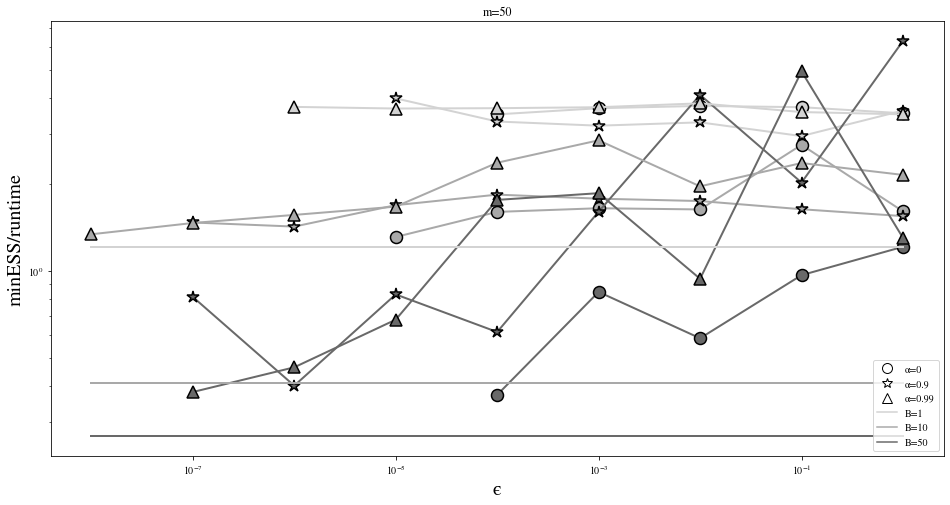

In [457]:
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
fig, ax = plt.subplots(figsize=(16, 8))
# α = 0.0
ax.plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 0), label='1T', marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 1), label='10T', marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 2), label='50T', marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.9
ax.plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 0), label='1α', marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 1), label='10α', marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 2), label='50α', marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.99
ax.plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 0), label='1α2', marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 1), label='10α2', marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 2), label='100α2', marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# CRWM
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 0), label='1C', color='lightgray', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 1), label='10C', color='darkgrey', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 2), label='50C', color='dimgrey', lw=CRWM_LINEWIDTH)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# Add a proper legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B=1')
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B=10')
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B=50')
ax.legend(handles=[circle, star, triangle, lightline, mediumline, darkline], loc='lower right')
plt.title("m=50")
plt.show()

# $m=100$

In [383]:
# Settings for 100-dimensional problem
SETTINGS100 = generate_setting(
    m=100,
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
    Bs=[1, 10, 50],
    δ=0.01,
    n_chains=4,
    n_samples=1000
)

In [384]:
# THUG 0.0 m=100
OUT1_100, OUT2_100 = compute_avg_cc_thug(SETTINGS100, α=0.0)

# THUG 0.9 m=100
OUT3_100, OUT4_100 = compute_avg_cc_thug(SETTINGS100, α=0.9)

# THUG 0.99 m=100
OUT5_100, OUT6_100 = compute_avg_cc_thug(SETTINGS100, α=0.99)

# C-RWM m=100
OUT7_100, OUT8_100 = compute_avg_cc_crwm(SETTINGS100, tol=1e-14, rev_tol=1e-14)

In [458]:
# Same but without final check on a in zappa_project
OUT7_100_2, OUT8_100_2 = compute_avg_cc_crwm(SETTINGS100, tol=1e-14, rev_tol=1e-14)

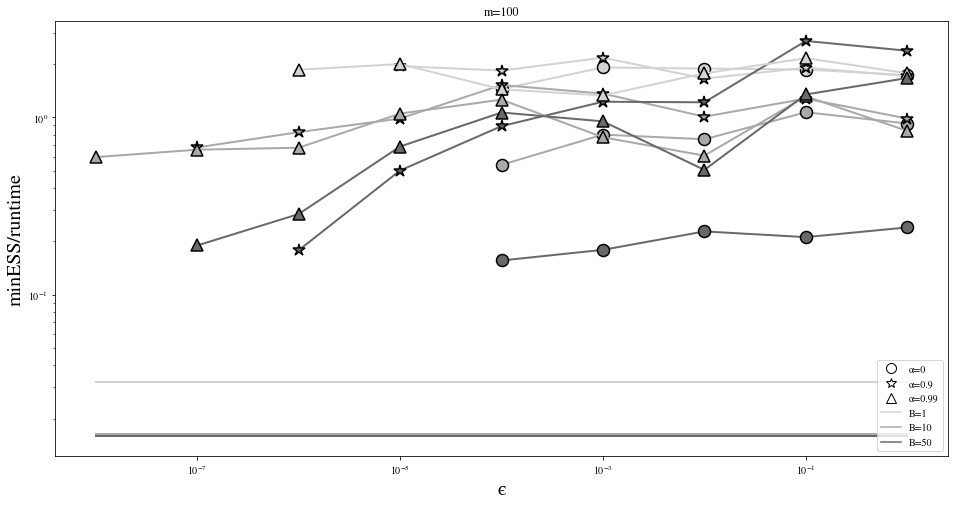

In [459]:
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
fig, ax = plt.subplots(figsize=(16, 8))
# α = 0.0
ax.plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 0), label='1T', marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 1), label='10T', marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 2), label='50T', marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.9
ax.plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 0), label='1α', marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 1), label='10α', marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 2), label='50α', marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.99
ax.plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 0), label='1α2', marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 1), label='10α2', marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 2), label='100α2', marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# CRWM
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 0), label='1C', color='lightgray', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 1), label='10C', color='darkgrey', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 2), label='50C', color='dimgrey', lw=CRWM_LINEWIDTH)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# Add a proper legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B=1')
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B=10')
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B=50')
ax.legend(handles=[circle, star, triangle, lightline, mediumline, darkline], loc='lower right')
plt.title("m=100")
plt.show()

# $m=200$

In [396]:
# Settings for 200-dimensional problem
SETTINGS200 = generate_setting(
    m=200,
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
    Bs=[1, 10, 50],
    δ=0.01,
    n_chains=4,
    n_samples=1000
)

In [397]:
# THUG 0.0 m=200
OUT1_200, OUT2_200 = compute_avg_cc_thug(SETTINGS200, α=0.0)

# THUG 0.9 m=200
OUT3_200, OUT4_200 = compute_avg_cc_thug(SETTINGS200, α=0.9)

# THUG 0.99 m=200
OUT5_200, OUT6_200 = compute_avg_cc_thug(SETTINGS200, α=0.99)

# C-RWM m=200
OUT7_200, OUT8_200 = compute_avg_cc_crwm(SETTINGS200, tol=1e-14, rev_tol=1e-14)

In [460]:
# Same but now without the check on ||a|| in zappa_project
OUT7_200_2, OUT8_200_2 = compute_avg_cc_crwm(SETTINGS200, tol=1e-14, rev_tol=1e-14)

In [461]:
print("Finished!\nFinished!\nFinished!\nFinished!\nFinished!\nFinished!")

Finished!
Finished!
Finished!
Finished!
Finished!
Finished!


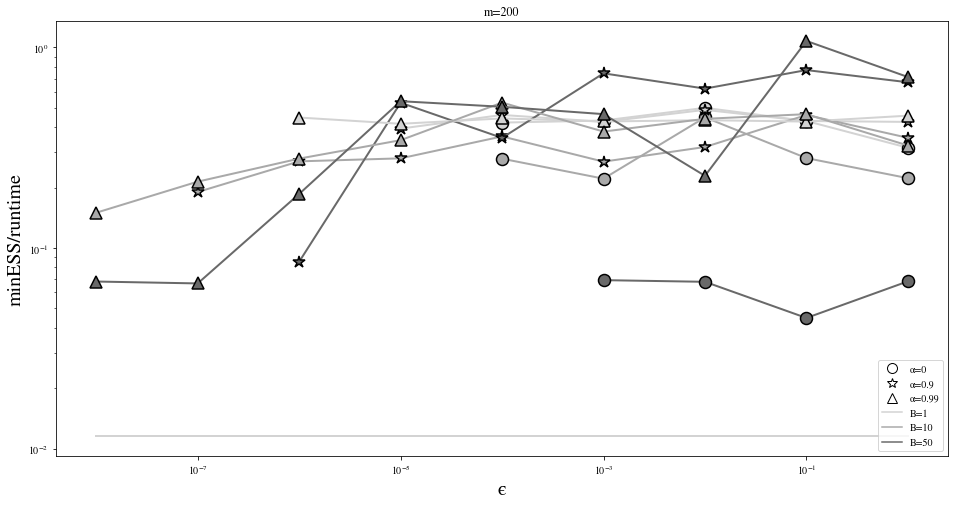

In [462]:
rc('font',**{'family':'STIXGeneral'})
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
fig, ax = plt.subplots(figsize=(16, 8))
# α = 0.0
ax.plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 0), label='1T', marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 1), label='10T', marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 2), label='50T', marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.9
ax.plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 0), label='1α', marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 1), label='10α', marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 2), label='50α', marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.99
ax.plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 0), label='1α2', marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 1), label='10α2', marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax.plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 2), label='100α2', marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# CRWM
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 0), label='1C', color='lightgray', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 1), label='10C', color='darkgrey', lw=CRWM_LINEWIDTH)
ax.plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 2), label='50C', color='dimgrey', lw=CRWM_LINEWIDTH)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# Add a proper legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B=1')
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B=10')
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B=50')
ax.legend(handles=[circle, star, triangle, lightline, mediumline, darkline], loc='lower right')
plt.title("m=200")
plt.show()

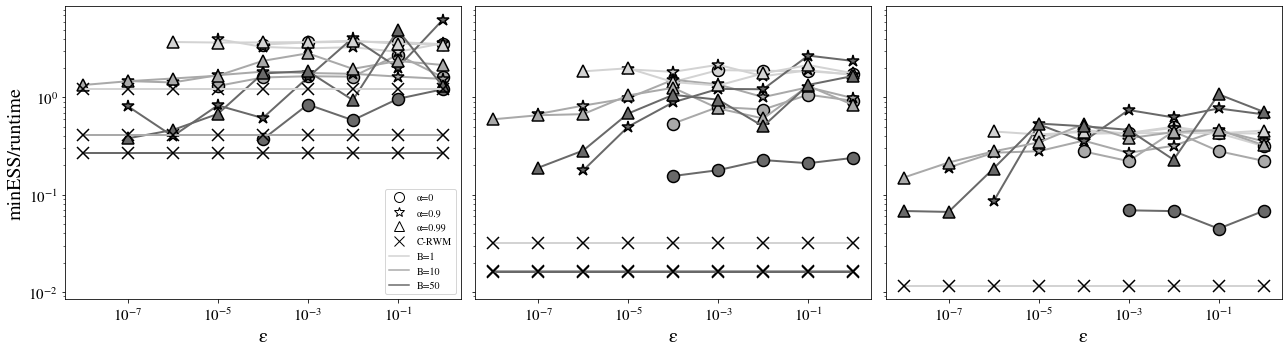

In [687]:
# Functions returning axes for different values of m.
m50  = (0)
m100 = (1)
m200 = (2)
# Settings
rc('font',**{'family':'STIXGeneral'})
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2

# Make one big figure
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True, sharex=True)
######## m=50 ###########
## α = 0.0
ax[m50].plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 0), marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 1), marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT1_50, OUT2_50, 2), marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## α=0.9
ax[m50].plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 0), marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 1), marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT3_50, OUT4_50, 2), marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## α=0.99
ax[m50].plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 0), marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 1), marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap(OUT5_50, OUT6_50, 2), marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## CRWM
ax[m50].plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 0), marker='x', color='lightgray', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 1), marker='x', color='darkgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m50].plot(ϵs, show_only_positive_ap_crwm(OUT7_50_2, OUT8_50_2, ϵs, 2), marker='x', color='dimgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
######## m=100 ###########
## α=0.0
ax[m100].plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 0), marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 1), marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT1_100, OUT2_100, 2), marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## α = 0.9
ax[m100].plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 0), marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 1), marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT3_100, OUT4_100, 2), marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## α = 0.99
ax[m100].plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 0), marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 1), marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap(OUT5_100, OUT6_100, 2), marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
## CRWM
ax[m100].plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 0), marker='x', color='lightgray', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 1), marker='x', color='darkgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m100].plot(ϵs, show_only_positive_ap_crwm(OUT7_100_2, OUT8_100_2, ϵs, 2), marker='x', color='dimgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
######## m=200 ###########
## α=0.0
# α = 0.0
ax[m200].plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 0), marker='o', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 1), marker='o', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT1_200, OUT2_200, 2), marker='o', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.9
ax[m200].plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 0), marker='*', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 1), marker='*', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT3_200, OUT4_200, 2), marker='*', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# α = 0.99
ax[m200].plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 0), marker='^', color='lightgray', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 1), marker='^', color='darkgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap(OUT5_200, OUT6_200, 2), marker='^', color='dimgrey', markersize=MARKERSIZE, markeredgecolor='k', lw=LINEWIDTH, markeredgewidth=MARKEREDGEWIDTH)
# CRWM
ax[m200].plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 0), marker='x', color='lightgray', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 1), marker='x', color='darkgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
ax[m200].plot(ϵs, show_only_positive_ap_crwm(OUT7_200_2, OUT8_200_2, ϵs, 2), marker='x', color='dimgrey', lw=CRWM_LINEWIDTH, markersize=MARKERSIZE, markeredgecolor='k', markeredgewidth=MARKEREDGEWIDTH)
# Prettify
for i in range(3):
    ax[i].set_xticks(ϵs)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
    ax[i].loglog()
ax[0].set_ylabel("minESS/runtime", fontsize=20)
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B=1')
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B=10')
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B=50')
ax[0].legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
plt.tight_layout()
plt.savefig('figures/gk_comp_cost_as_dimension_increases_no_check_on_a_bigger.png', dpi=300)
plt.show()

# Plot Posteriors at best epsilon

We do this only for $m=50$. We start from a point containing the true parameter $\theta_0$ to simulate convergence.

In [480]:
# Find θ0 but in N(0, 1) space
θ0_normal = Ginv(θ0)

In [481]:
# Find a point on the manifold having θ0 in it.
ξ0_50 = find_point_on_manifold_from_θ(SETTINGS50['ystar'], θ0_normal, 1e-5, maxiter=5000)

In [525]:
# Set a stepsize for all algorithms
δ_best_eps = SETTINGS50['δ']
B_best_eps = 5
ϵs_best_eps = [10.0, *SETTINGS50['ϵs']]

# Manifold for all algorithms
manifold_best_eps = GKManifold(SETTINGS50['ystar'])

In [537]:
def check_which_epsilon_RWM(ξ0_50, B_best_eps, δ_best_eps, ϵs, manifold_best_eps, N=1000):
    """Can be used to check which epsilon allows a non-zero acceptance probability."""
    ap = {}
    for ϵ in ϵs:
        logηϵ = manifold_best_eps.generate_logηε(ϵ)
        ap[ϵ] = RWM(ξ0_50, B_best_eps*δ_best_eps, N, logηϵ)[1].mean()*100
    return ap

def check_which_epsilon_THUG(ξ0_50, B_best_eps, δ_best_eps, ϵs, manifold_best_eps, N=1000, α=0.0):
    """Same as above."""
    ap = {}
    dimension = len(ξ0_50)
    q = MVN(zeros(dimension), eye(dimension))
    for ϵ in ϵs:
        logηϵ = manifold_best_eps.generate_logηε(ϵ)
        ap[ϵ] = HugTangentialMultivariate(ξ0_50, B_best_eps*δ_best_eps, B_best_eps, N, α, q, logηϵ, manifold_best_eps.fullJacobian, method='linear')[1].mean()*100
    return ap



In [529]:
check_which_epsilon_RWM(ξ0_50, B_best_eps, δ_best_eps, ϵs_best_eps, manifold_best_eps)

{10.0: 32.1,
 1.0: 0.0,
 0.1: 0.0,
 0.01: 0.0,
 0.001: 0.0,
 0.0001: 0.0,
 1e-05: 0.0,
 1e-06: 0.0,
 1e-07: 0.0,
 1e-08: 0.0}

In [538]:
check_which_epsilon_THUG(ξ0_50, B_best_eps, δ_best_eps, ϵs_best_eps, manifold_best_eps, N=1000, α=0.0)

{10.0: 85.39999999999999,
 1.0: 84.1,
 0.1: 84.8,
 0.01: 83.3,
 0.001: 68.5,
 0.0001: 9.3,
 1e-05: 0.0,
 1e-06: 0.0,
 1e-07: 0.0,
 1e-08: 0.0}

In [539]:
check_which_epsilon_THUG(ξ0_50, B_best_eps, δ_best_eps, ϵs_best_eps, manifold_best_eps, N=1000, α=0.9)

{10.0: 87.6,
 1.0: 90.2,
 0.1: 87.2,
 0.01: 89.0,
 0.001: 90.3,
 0.0001: 73.4,
 1e-05: 10.6,
 1e-06: 0.0,
 1e-07: 0.0,
 1e-08: 0.0}

In [540]:
check_which_epsilon_THUG(ξ0_50, B_best_eps, δ_best_eps, ϵs_best_eps, manifold_best_eps, N=1000, α=0.99)

{10.0: 90.10000000000001,
 1.0: 88.4,
 0.1: 88.7,
 0.01: 87.9,
 0.001: 88.2,
 0.0001: 87.6,
 1e-05: 66.3,
 1e-06: 8.9,
 1e-07: 0.0,
 1e-08: 0.0}

In [541]:
check_which_epsilon_THUG(ξ0_50, B_best_eps, δ_best_eps, ϵs_best_eps, manifold_best_eps, N=1000, α=0.999)

{10.0: 88.4,
 1.0: 85.6,
 0.1: 87.8,
 0.01: 87.2,
 0.001: 88.2,
 0.0001: 86.5,
 1e-05: 70.3,
 1e-06: 39.2,
 1e-07: 3.6999999999999997,
 1e-08: 0.1}

In [672]:
# Based on results above, set the best epsilons
ϵ_RWM     = 10.0
ϵ_HUG     = 1e-3
ϵ_THUG99  = 1e-5
ϵ_THUG999 = 1e-5

In [548]:
N_best_eps = 50000
q = MVN(zeros(54), eye(54))

In [673]:
logηϵ_RWM = manifold_best_eps.generate_logηε(ϵ_RWM)
logηϵ_HUG = manifold_best_eps.generate_logηε(ϵ_HUG)
logηϵ_THUG99 = manifold_best_eps.generate_logηε(ϵ_THUG99)
logηϵ_THUG999 = manifold_best_eps.generate_logηε(ϵ_THUG999)

In [545]:
sRWM_be, aRWM_be = RWM(ξ0_50, B_best_eps*δ_best_eps, N_best_eps, logηϵ_RWM)

In [572]:
sHUG_be, aHUG_be = HugTangentialMultivariate(ξ0_50, B_best_eps*δ_best_eps, B_best_eps, N_best_eps, 0.0, q, logηϵ_HUG, manifold_best_eps.fullJacobian, method='linear')

In [674]:
sTHUG999_be, aTHUG999_be = HugTangentialMultivariate(ξ0_50, B_best_eps*δ_best_eps, B_best_eps, N_best_eps, 0.999, q, logηϵ_THUG999, manifold_best_eps.fullJacobian, method='linear')

In [604]:
sTHUG99_be, aTHUG99_be = HugTangentialMultivariate(ξ0_50, B_best_eps*δ_best_eps, B_best_eps, N_best_eps, 0.99, q, logηϵ_THUG99, manifold_best_eps.fullJacobian, method='linear')

In [654]:
sCRWM_be, _, aCRWM_be = zappa_sampling_storecomps_rattle(ξ0_50, manifold_best_eps, N_best_eps, B_best_eps*δ_best_eps, B_best_eps, tol=1e-14, rev_tol=1e-8)

In [675]:
# Remember I need to transform back to the original U(0, 10) space. 
sRWM_be_transformed_θ = G(sRWM_be[:, :4])
sHUG_be_transformed_θ = G(sHUG_be[:, :4])
sTHUG99_be_transformed_θ = G(sTHUG99_be[:, :4])
sTHUG999_be_transformed_θ = G(sTHUG999_be[:, :4])
sCRWM_be_transformed_θ = G(sCRWM_be[:, :4])

In [677]:
prangle_mcmc_samples = np.loadtxt(
    'ManifoldSamplingR/gk_mcmc_samples2.txt', skiprows=1, usecols=range(1, 5)
)[1:, :]

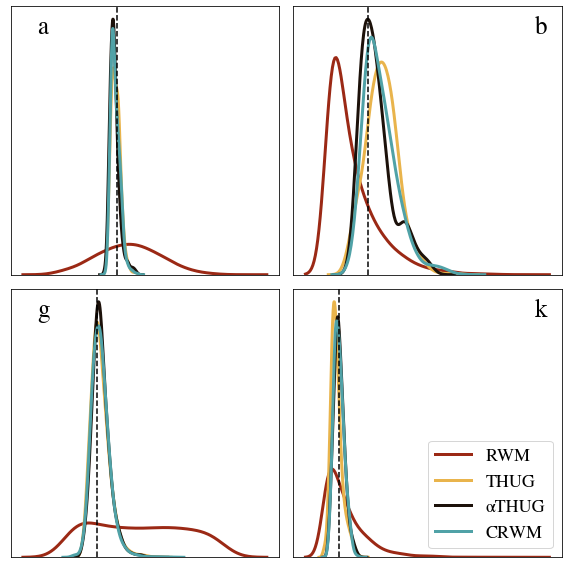

In [684]:
BW = 0.3
LW = 3
FROM = 0
LABELS = ['a', 'b', 'g', 'k']
COLOR_THUG = "#1C110A"  # Dark Grey
COLOR_HUG  = "#E9B44C"  # Dark Yellow
COLOR_CRWM = "#50A2A7"  # Light Blue
COLOR_RWM  = "#E4D6A7"  # Light Yellow
COLOR_HMC  = "#9B2915"  # Dark Red
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for i in range(4):
    _ = sns.kdeplot(sRWM_be_transformed_θ[FROM:, i], bw_method=BW, ax=ax[i//2, i%2], lw=LW, label='RWM', color=COLOR_HMC)
    _ = sns.kdeplot(sHUG_be_transformed_θ[FROM:, i], bw_method=BW, ax=ax[i//2, i%2], lw=LW, label='THUG', color=COLOR_HUG)
    _ = sns.kdeplot(sTHUG999_be_transformed_θ[FROM:, i], bw_method=BW, ax=ax[i//2, i%2], lw=LW, label='αTHUG', color=COLOR_THUG)
    _ = sns.kdeplot(sCRWM_be_transformed_θ[FROM:, i], bw_method=BW, ax=ax[i//2, i%2], lw=LW, label='CRWM', color=COLOR_CRWM)
#     _ = sns.kdeplot(prangle_mcmc_samples[FROM:, i], bw_method=BW, ax=ax[i//2, i%2], lw=LW, label='MCMC', color=COLOR_RWM)
    min_val = min(sHUG_be_transformed_θ[FROM:, i].min(), sTHUG999_be_transformed_θ[FROM:, i].min(), sCRWM_be_transformed_θ[FROM:, i].min()) - 0.1
    max_val = max(sHUG_be_transformed_θ[FROM:, i].max(), sTHUG999_be_transformed_θ[FROM:, i].max(), sCRWM_be_transformed_θ[FROM:, i].max()) + 0.1
#     ax[i//2, i%2].set_xlim([min_val, max_val])
    ax[i//2, i%2].axvline(θ0[i], c='k', ls='--')
    ax[i//2, i%2].text(0.1 if (i%2 == 0) else 0.9, 0.9, "{}".format(LABELS[i]), transform=ax[i //2, i % 2].transAxes, fontsize=25, fontfamily='STIXGeneral')
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_yticks([])
    ax[i//2, i%2].set_xticks([])

plt.tight_layout()
plt.legend(prop={'family':'STIXGeneral', 'size':18}, loc='lower right')
plt.savefig("figures/gk_best_epsilon_no_prangle_no_hmc_crwm.png")
plt.show()